All necessary imports

In [13]:
import math
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, GlobalAveragePooling2D, Dense, MaxPool2D, AveragePooling2D, Flatten, Add, Concatenate

In [2]:
# loading the dataset
train_download, test_download = tfds.load("cifar10", split=["train", "test"], as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteB0XNQ6/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteB0XNQ6/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


Piping the dataset through the pipeline to prepare it.

In [3]:
def data_pipeline(data):
  """ Describtion here
  Args:
    data:
  Return:
    data:
  """

  data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))

  #normalization, brings image values from range [0, 255] to [-1, 1]
  data = data.map(lambda img, target: ((img/128.)-1., target))
  #data = data.map(lambda img, target: ((img/255.), target)) alternative?

  #create one-hot targets
  data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

  #cache progress in memory, as there is no need to redo it
  data = data.cache()

  #shuffle, batch, prefetch
  data = data.shuffle(1000)
  data = data.batch(64)
  data = data.prefetch(tf.data.AUTOTUNE)

  #return preprocessed dataset
  return data

# Models

ResBlock

In [4]:
class ResidualBlock(tf.keras.Model):

    def __init__(self, num_filters):

        super(ResidualBlock, self).__init__()

        self.batchnorm1 = BatchNormalization()
        self.activation1 = Activation("relu")
        self.convolution1 = Conv2D(filters=num_filters, kernel_size=(1,1))

        self.batchnorm2 = BatchNormalization()
        self.activation2 = Activation("relu")
        self.convolution1 = Conv2D(filters=num_filters, kernel_size=(3,3), padding="same")

        self.batchnorm3 = BatchNormalization()
        self.activation3 = Activation("relu")
        self.convolution3 = Conv2D(filters=num_filters, kernel_size=(1,1))

        self.add = Add()


    @tf.function
    def call(self, inputs, for_training=None):

        x = self.batchnorm1(inputs, training=for_training)
        x = self.activation1(x)
        x = self.convolution1(x)

        x = self.batchnorm2(x, training=for_training)
        x = self.activation2(x)
        x = self.convolution2(x)

        x = self.batchnorm3(x, training=for_training)
        x = self.activation3(x)
        x = self.convolution3(x)

        x = self.add([x, inputs])

        return x


ResNet Model

In [5]:
class ResNet(tf.keras.Model):

    def __init__(self, num_blocks, num_block_filters):

        super(ResNet, self).__init__()

        self.convolutional = Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same",  input_shape=(32, 32, 3))
        # self.bn = BatchNormalization()
        # self.pool = MaxPool2D(pool_size = 3,strides = 2)

        # residual blocks
        self.blocks = [ResidualBlock(num_filters=num_block_filters) for index in range(num_blocks)]

        # classification
        self.global_pool = GlobalAvgPool2D()
        self.out = Dense(10, kernel_regularizer="l1_l2", activation="softmax")


    @tf.function
    def call(self, inputs, for_training):
        
        x = self.convolutional(inputs)
        #x = self.bn(x,training=is_training)
        #x = tf.nn.relu(x)
        #x = self.pool(x)

        # residual blocks
        for resblock in self.blocks:
            x = block(x, training=for_training)

        # classification
        x = self.global_pool(x)
        x = self.out(x)

        return x

Transition Layer

In [6]:
class TransitionLayer(tf.keras.Model):

    def __init__(self, num_filters):

        super(TransitionLayer, self).__init__()

        self.convolutional = Conv2D(filters=num_filters, kernel_size=(1,1), padding="same")  # or maybe padding = valid?
        self.batchnorm = BatchNormalization()
        self.activation = Activation("relu")
        self.pooling = AveragePooling2D(pool_size = 2, strides=(2,2), padding="same") # maybe leave this out

    
    @tf.function
    def call(self, inputs, for_training=None):

        x = self.convolutional(inputs)
        x = self.batchnorm(x, training=for_training)
        x = self.activation(x)
        x = self.pooling(x)
        
        return x

DenseBlock

In [7]:
class DenseBlock(tf.keras.Model):

    def __init__(self, num_filters, new_channels):

        super(DenseBlock, self).__init__()

        self.batchnorm1 = BatchNormalization()
        self.activation1 = Activation("relu")
        self.convolution1 = Conv2D(filters=num_filters, kernel_size=(1,1), padding="valid")

        self.batchnorm2 = BatchNormalization()
        self.activation2 = Activation("relu")
        self.convolution2 = Conv2D(filters=new_channels, kernel_size=(3,3), padding="same")

        self.concat = Concatenate(axis=-1)

    
    @tf.function
    def call(self, inputs, for_training=None):

        x = self.batchnorm1(inputs, training=for_training)
        x = self.activation1(x)
        x = self.convolution1(x)

        x = self.batchnorm2(x, training=for_training)
        x = self.activation2(x)
        x = self.convolution2(x)

        x = self.concat([x, inputs])

        return x

DenseNet Model

In [8]:
class DenseNet(tf.keras.Model):

    def __init__(self, num_blocks, num_filters, new_channels, growth_rate):

        super(DenseNet, self).__init__()
        
        self.convolutional = Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3))
        self.batchnorm = BatchNormalization()

        self.blocks = []
        for index in range(num_blocks):
            self.blocks.append(DenseBlock(num_filters=num_filters, new_channels=new_channels))
            self.blocks.append(TransitionLayer(num_filters=growth_rate*2))
        self.blocks.append(DenseBlock(num_filters=num_filters, new_channels=new_channels))

        self.global_pool = GlobalAveragePooling2D()
        self.out = Dense(10, activation="softmax")


    @tf.function
    def call(self, inputs, for_training=None):

        x = self.convolutional(inputs)
        x = self.batchnorm(x, training=for_training)
        
        for index in range(len(self.blocks)):
            x = self.blocks[index](x, training=for_training)
        
        x = self.global_pool(x)
        x = self.out(x)
        
        return x

# Training and Testing
Implementation of test and training functions

In [9]:
@tf.function
def train_step(model, inputs, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(inputs, for_training=True)
        # model.losses then need to reduce to single value
        loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss


def test(model, test_data, loss_function):
    # test over complete test data
    test_accuracy_aggregator = np.empty(0)
    test_loss_aggregator = np.empty(0)

    for (input, target) in test_data:
        prediction = model(input, for_training=False)
        #print(prediction.shape)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator = np.append(test_loss_aggregator, sample_test_loss)
        test_accuracy_aggregator = np.append(test_accuracy_aggregator, sample_test_accuracy)
    
    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

Execution of training and testing on the models

In [10]:
tf.keras.backend.clear_session()

# Prepare the data
test_dataset = data_pipeline(test_download)
train_dataset = data_pipeline(train_download)

### Hyperparameters
num_epochs = 30
learning_rate = 0.001  # tf.constant(0.001, dtype=tf.float32)

# Initialize the model
model = DenseNet(num_blocks=2, num_filters=128, new_channels=32, growth_rate=32)

# Initialize the loss function.
global_loss_function = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer:
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize numpy arrays for later visualization
train_losses = np.empty(0)
test_losses = np.empty(0)
test_accuracies = np.empty(0)
train_accuracies = np.empty(0)

# testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, global_loss_function)
test_losses = np.append(test_losses, test_loss)
test_accuracies = np.append(test_accuracies, test_accuracy)

# check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, global_loss_function)
train_losses = np.append(train_losses, train_loss)

model.summary()

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    # Display accuracy at the beginning of each epoch
    print(f'Epoch: {str(epoch)} starting with test accuracy {test_accuracies[-1]}')

    # Iterating over the data set and checking in with training
    epoch_loss_agg = np.empty(0)
    for input, target in train_dataset:
        train_loss = train_step(model, input, target, global_loss_function, optimizer)
        epoch_loss_agg = np.append(epoch_loss_agg, train_loss)

    # Track training loss
    train_losses = np.append(train_losses, tf.reduce_mean(epoch_loss_agg))
    
    # Computing train accuracy
    _, train_accuracy = test(model, train_dataset, global_loss_function)
    train_accuracies = np.append(train_accuracies, train_accuracy)

    # Display train accuracy
    print(f'Epoch: {str(epoch)} finishing with train accuracy {train_accuracies[-1]}')
    print(" ")

    # Computing test loss and accuracy
    test_loss, test_accuracy = test(model, test_dataset, global_loss_function)
    test_losses = np.append(test_losses, test_loss)
    test_accuracies = np.append(test_accuracies, test_accuracy)

Model: "dense_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  896       
                                                                 
 batch_normalization (BatchN  multiple                 128       
 ormalization)                                                   
                                                                 
 dense_block (DenseBlock)    multiple                  41760     
                                                                 
 transition_layer (Transitio  multiple                 4416      
 nLayer)                                                         
                                                                 
 dense_block_1 (DenseBlock)  multiple                  45984     
                                                                 
 transition_layer_1 (Transit  multiple                 64

# Visualization and Explanation

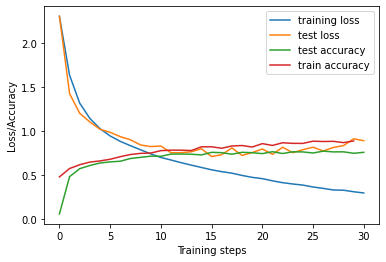

In [14]:
# Visualize accuracy and loss for training and test data
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
line4, = plt.plot(train_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1, line2, line3, line4), ("training loss", "test loss", "test accuracy", "train accuracy"))
plt.show()